**Experiment 1**

In [1]:
#Cell 1 — Install dependencies
!pip -q install opacus==1.4.0 tqdm pandas matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 22.8 MB/s eta 0:00:00


In [2]:
#Cell 2 — Imports + reproducibility
import os, math, random, re, subprocess
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

from opacus.accountants import RDPAccountant

# Wider alpha grid => avoids "optimal order is the largest alpha" warning
RDP_ALPHAS = (
    [1.01, 1.05] +
    [1.1 + 0.1*i for i in range(0, 90)] +      # 1.1..10.0
    list(range(11, 64)) + [64, 128, 256, 512]
)

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
#Cell 3 — Download Fashion‑MNIST
#torchvision downloads it automatically.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print(len(train_ds), len(test_ds))

100%|██████████| 26.4M/26.4M [00:11<00:00, 2.20MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.9MB/s]

60000 10000


In [4]:
#Cell 4 — Make 6000 clients × 10 samples/client (FedVRDP-style)
def make_cross_device_clients(train_dataset, num_clients=6000, samples_per_client=10, seed=0):
    assert num_clients * samples_per_client <= len(train_dataset)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_dataset)).tolist()
    clients = []
    for c in range(num_clients):
        clients.append(idx[c*samples_per_client:(c+1)*samples_per_client])
    return clients

clients = make_cross_device_clients(train_ds, num_clients=6000, samples_per_client=10, seed=0)
print("num clients:", len(clients), "samples/client:", len(clients[0]))

num clients: 6000 samples/client: 10


In [5]:
#Cell 5 — Optional “public anchor set” (2 samples/class)
#If we want to skip this, set public_idx = [] and don’t filter.
def extract_public_per_class(dataset, per_class=2, seed=0):
    rng = np.random.default_rng(seed)
    targets = np.array(dataset.targets)
    public_idx = []
    for k in range(10):
        cls_idx = np.where(targets == k)[0]
        rng.shuffle(cls_idx)
        public_idx.extend(cls_idx[:per_class].tolist())
    public_idx = sorted(public_idx)
    return public_idx

public_idx = extract_public_per_class(train_ds, per_class=2, seed=0)
public_loader = DataLoader(Subset(train_ds, public_idx), batch_size=20, shuffle=False)

# Remove public samples from clients so they are not used privately
public_set = set(public_idx)
clients_wo_public = []
for cid in range(len(clients)):
    filtered = [i for i in clients[cid] if i not in public_set]
    clients_wo_public.append(filtered)

clients = clients_wo_public
print("public samples:", len(public_idx), "| example client size after removal:", len(clients[0]))

public samples: 20 | example client size after removal: 10


In [6]:
#Cell 6 — Model (CNN like FedVRDP description)
#FedVRDP describes a CNN with 2 conv layers, maxpool, ReLU, FC(512).
class FMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # 28->24
        x = F.max_pool2d(x, 2)          # 24->12
        x = F.relu(self.conv2(x))       # 12->8
        x = F.max_pool2d(x, 2)          # 8->4
        x = x.view(x.size(0), -1)       # 64*4*4
        x = F.relu(self.fc1(x))
        return self.fc2(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

In [7]:
#Cell 7 — Tensor-list utilities (fast, no giant flatten)
def model_param_list(model):
    return [p for p in model.parameters() if p.requires_grad]

@torch.no_grad()
def zero_like_params(model):
    return [torch.zeros_like(p) for p in model_param_list(model)]

@torch.no_grad()
def add_update_(model, update_list, scale=1.0):
    for p, u in zip(model_param_list(model), update_list):
        p.data.add_(u, alpha=scale)

@torch.no_grad()
def l2_norm_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return torch.sqrt(s + 1e-12)

@torch.no_grad()
def dot_list(a_list, b_list):
    s = None
    for a, b in zip(a_list, b_list):
        v = (a*b).sum()
        s = v if s is None else s + v
    return s

@torch.no_grad()
def add_scaled_list_(dst, src, alpha):
    for d, s in zip(dst, src):
        d.add_(s, alpha=alpha)

@torch.no_grad()
def sub_list(a, b):
    return [x - y for x, y in zip(a, b)]

In [8]:
#Cell 8 — Local client training (returns update = local_model − global_model)
def client_update(global_model, client_indices, lr, momentum, local_epochs, batch_size=10):
    local_model = deepcopy(global_model)
    local_model.train()

    loader = DataLoader(Subset(train_ds, client_indices),
                        batch_size=batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(local_epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    # delta = local - global
    delta = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta.append((lp.data - gp.data).detach())
    return delta

In [9]:
#Cell 9 — DP accounting helpers (compute noise multiplier for target ε)
#We will use RDP accountant_toggle: sample rate  𝑞=clients per round/total clients, steps = rounds.
#(Opacus 1.4.0 compatible)

from opacus.accountants import RDPAccountant

def epsilon_from_sigma_dp_sgd(sigma, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma, sample_rate=q)
    return acc.get_epsilon(delta)

def epsilon_from_sigma_two_mech(sigma_sel, sigma_rel, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma_sel, sample_rate=q)  # selection
        acc.step(noise_multiplier=sigma_rel, sample_rate=q)  # release
    return acc.get_epsilon(delta)

def find_sigma_for_target_eps_single(target_eps, q, steps, delta, lo=0.1, hi=80.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_dp_sgd(mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def find_sigma_for_target_eps_two(target_eps, q, steps, delta, sel_factor=4.0, lo=0.1, hi=200.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_two_mech(sel_factor*mid, mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def report_noise_scales(target_eps, q, rounds, delta, C, M, rho, tau, sel_factor):
    nm_fedavg = find_sigma_for_target_eps_single(target_eps, q, rounds, delta)
    nm_rel    = find_sigma_for_target_eps_two(target_eps, q, rounds, delta, sel_factor=sel_factor)
    nm_sel    = sel_factor * nm_rel

    noise_mean = nm_fedavg * (C / M)     # DP-FedAvg released mean noise std
    noise_rel  = nm_rel * (rho / tau)    # AG-PTR released update noise std (conservative, denom>=tau)

    achieved = epsilon_from_sigma_two_mech(nm_sel, nm_rel, q, rounds, delta)

    print(f"Target eps_total = {target_eps}")
    print(f"q={q:.4f}, rounds={rounds}, delta={delta}")
    print(f"[DP-FedAvg] nm={nm_fedavg:.4f}  -> noise_std_on_mean = {noise_mean:.6g} (C/M)")
    print(f"[AG-PTR]   nm_sel={nm_sel:.4f}")
    print(f"[AG-PTR]   nm_rel={nm_rel:.4f} -> noise_std_on_release ≈ {noise_rel:.6g} (rho/tau)")
    print(f"[AG-PTR] achieved eps ≈ {achieved:.3f} (target {target_eps})")
    print(f"Noise ratio (AG-PTR / FedAvg) = {noise_rel/(noise_mean+1e-12):.3f}")




In [10]:
#Cell 10 — DP‑FedAvg training loop
def train_dp_fedavg(seed, eps_total, delta=1e-5,
                    num_clients=6000, clients_per_round=100,
                    rounds=180, local_epochs=10, batch_size=10,
                    lr0=0.125, lr_decay=0.99, momentum=0.5,
                    clip_C=1.0):

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    sigma = find_sigma_for_target_eps_single(eps_total, q, rounds, delta)
    achieved_eps = epsilon_from_sigma_dp_sgd(sigma, q, rounds, delta)

    mean_noise_std = sigma * (clip_C / clients_per_round)
    print(f"[DP-FedAvg] target eps={eps_total} -> nm={sigma:.4f}, achieved eps≈{achieved_eps:.3f}, mean-noise-std≈{mean_noise_std:.6g}")

    for t in tqdm(range(rounds), desc=f"DP-FedAvg eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        sum_update = zero_like_params(model)

        for cid in chosen:
            delta_i = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                    local_epochs=local_epochs, batch_size=batch_size)

            norm = l2_norm_list(delta_i)
            scale = min(1.0, clip_C / (norm.item() + 1e-12))
            add_scaled_list_(sum_update, delta_i, scale)

        # add Gaussian noise to the SUM (std = sigma * C)
        for j in range(len(sum_update)):
            sum_update[j].add_(torch.randn_like(sum_update[j]) * (sigma * clip_C))

        avg_update = [u / clients_per_round for u in sum_update]
        add_update_(model, avg_update, scale=1.0)

    acc = evaluate(model, test_loader)
    return acc, achieved_eps, sigma


In [11]:
# Cell 11 — AG‑PTR (public anchor + zero fallback) with pub_scale

def norm_sq_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return (s + 1e-12)

def public_anchor_update(global_model, public_indices, lr, momentum, public_epochs=1, public_batch_size=None):
    """
    Compute delta_pub = (w_pub - w_global) by training on the public set starting at w_global.
    Uses SAME optimizer family (SGD), SAME lr and momentum as clients (as you described in the paper).
    Returns list-of-tensors delta_pub on device.
    """
    if public_indices is None or len(public_indices) == 0:
        raise ValueError("public_indices is empty. Build public_idx first.")

    local_model = deepcopy(global_model).to(device)
    local_model.train()

    bs = len(public_indices) if (public_batch_size is None) else int(public_batch_size)
    loader = DataLoader(Subset(train_ds, public_indices), batch_size=bs, shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(int(public_epochs)):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    delta_pub = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta_pub.append((lp.data - gp.data).detach())
    return delta_pub


def train_ag_ptr(seed, eps_total, delta=1e-5,
                 num_clients=6000, clients_per_round=100,
                 rounds=30, local_epochs=2, batch_size=10,
                 lr0=0.125, lr_decay=0.99, momentum=0.5,
                 rho=0.79, tau=80, sel_factor=2.0,
                 public_indices=None, public_epochs=1, public_batch_size=None,
                 pub_scale=0.1,
                 debug=True):

    """
    AG‑PTR with A_t = { pub_scale * delta_pub_t , 0 }.

    Phase 1: DP noisy counts (2 anchors), select winner, gate with tau.
    Phase 2: anchored mean of rho-clipped offsets + Gaussian noise.

    Returns: acc, achieved_eps, (nm_sel, nm_rel), accept_rate, avg_contrib, clip_rate
    """

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    # Two Gaussian mechanisms per round (selection + release), tied by sel_factor
    nm_rel = find_sigma_for_target_eps_two(eps_total, q, rounds, delta, sel_factor=sel_factor)
    nm_sel = sel_factor * nm_rel
    achieved_eps = epsilon_from_sigma_two_mech(nm_sel, nm_rel, q, rounds, delta)

    if debug:
        print(f"[AG-PTR] eps={eps_total} -> nm_rel={nm_rel:.4f}, nm_sel={nm_sel:.4f}, achieved eps≈{achieved_eps:.3f} | pub_scale={pub_scale}")

    zero_anchor = zero_like_params(model)

    accept_count = 0
    total_contrib = 0
    clip_count = 0
    total_considered = 0

    winner_all = np.zeros(2, dtype=int)
    winner_acc = np.zeros(2, dtype=int)

    for t in tqdm(range(rounds), desc=f"AG-PTR eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        # --- build public anchor for this round ---
        delta_pub = public_anchor_update(
            model, public_indices,
            lr=lr_t, momentum=momentum,
            public_epochs=public_epochs,
            public_batch_size=public_batch_size
        )
        a_pub = [pub_scale * d for d in delta_pub]  # <-- pub_scale is applied here
        a_pub_norm = norm_sq_list(a_pub).item()

        # --- compute each sampled client update ONCE ---
        deltas = []
        assign = []  # 0 => public anchor, 1 => zero anchor
        n_pub = 0

        for cid in chosen:
            delta_i = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                    local_epochs=local_epochs, batch_size=batch_size)
            deltas.append(delta_i)

            # distance to zero: ||delta||^2
            d0 = norm_sq_list(delta_i).item()

            # distance to public: ||delta - a_pub||^2 = ||delta||^2 + ||a_pub||^2 - 2<delta, a_pub>
            dp = d0 + a_pub_norm - 2.0 * dot_list(delta_i, a_pub).item()

            if dp <= d0:
                assign.append(0)
                n_pub += 1
            else:
                assign.append(1)

        n_zero = clients_per_round - n_pub

        # --- Phase 1: DP noisy counts ---
        noisy_pub = n_pub  + np.random.normal(0.0, nm_sel)
        noisy_zero = n_zero + np.random.normal(0.0, nm_sel)

        r_star = 0 if (noisy_pub >= noisy_zero) else 1
        noisy_winner = noisy_pub if (r_star == 0) else noisy_zero

        winner_all[r_star] += 1

        if noisy_winner < tau:
            # reject: no update
            continue

        accept_count += 1
        winner_acc[r_star] += 1

        # winner anchor
        a_star = a_pub if (r_star == 0) else zero_anchor

        # --- Phase 2: release anchored mean ---
        sum_offsets = zero_like_params(model)

        contrib = 0
        for delta_i, r_i in zip(deltas, assign):
            if r_i != r_star:
                continue

            contrib += 1
            total_considered += 1

            offset = sub_list(delta_i, a_star)
            off_norm = l2_norm_list(offset).item()

            scale = min(1.0, rho / (off_norm + 1e-12))
            if scale < 1.0:
                clip_count += 1

            add_scaled_list_(sum_offsets, offset, scale)

        total_contrib += contrib

        m_hat = max(float(tau), float(noisy_winner))  # DP-safe post-processing

        # Add Gaussian noise to SUM offsets (std = nm_rel * rho)
        for j in range(len(sum_offsets)):
            sum_offsets[j].add_(torch.randn_like(sum_offsets[j]) * (nm_rel * rho))

        mean_update = [a + (so / m_hat) for a, so in zip(a_star, sum_offsets)]
        add_update_(model, mean_update, scale=1.0)

    acc = evaluate(model, test_loader)
    accept_rate = accept_count / rounds
    avg_contrib = (total_contrib / accept_count) if accept_count > 0 else 0.0
    clip_rate = (clip_count / total_considered) if total_considered > 0 else 0.0

    if debug:
        print("\n[AG-PTR debug] Winner histogram (all rounds):", winner_all, "sum=", winner_all.sum())
        print("[AG-PTR debug] Winner histogram (accepted rounds):", winner_acc, "sum=", winner_acc.sum())

    return acc, achieved_eps, (nm_sel, nm_rel), accept_rate, avg_contrib, clip_rate


In [12]:
# Cell 12 — Calibrate pub_scale on a 30‑round pilot (FedAvg vs AG‑PTR only)

import pandas as pd
import numpy as np
import os

# Pilot settings (keep cheap)
NUM_CLIENTS = 6000
M = 100
ROUNDS_PILOT = 30
LOCAL_EPOCHS_PILOT = 2
DELTA = 1e-5
SEED = 1

# DP / training settings
CLIP_C = 1.0
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

# AG‑PTR hyperparams (fix these, tune ONLY pub_scale)
EPS = 1              # tune at eps=1 (hardest privacy), then reuse for eps=2,4
TAU = 80
RHO = 0.79
SEL_FACTOR = 2.0
PUB_EPOCHS = 1
PUB_BS = len(public_idx)

PUB_SCALE_GRID = [0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

q = M / NUM_CLIENTS
print("----- noise sanity (release) -----")
print(f"C/M={CLIP_C/M:.6f} | rho/tau={RHO/TAU:.6f} | ratio={(RHO/TAU)/(CLIP_C/M):.3f}")

print("\n----- DP‑FedAvg pilot (reference) -----")
acc_fa, _, nm_fa = train_dp_fedavg(
    SEED, EPS, delta=DELTA,
    num_clients=NUM_CLIENTS, clients_per_round=M,
    rounds=ROUNDS_PILOT, local_epochs=LOCAL_EPOCHS_PILOT, batch_size=10,
    lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
    clip_C=CLIP_C
)
print(f"FedAvg acc={acc_fa:.4f} | nm={nm_fa:.4f}")

rows = []
print("\n----- AG‑PTR pub_scale sweep -----")
for s in PUB_SCALE_GRID:
    acc_ag, _, (nm_sel, nm_rel), ar, avg_contrib, clip_rate = train_ag_ptr(
        SEED, EPS, delta=DELTA,
        num_clients=NUM_CLIENTS, clients_per_round=M,
        rounds=ROUNDS_PILOT, local_epochs=LOCAL_EPOCHS_PILOT, batch_size=10,
        lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
        rho=RHO, tau=TAU, sel_factor=SEL_FACTOR,
        public_indices=public_idx, public_epochs=PUB_EPOCHS, public_batch_size=PUB_BS,
        pub_scale=s,
        debug=True
    )
    rows.append({
        "pub_scale": s,
        "acc": float(acc_ag),
        "accept": float(ar),
        "avg_contrib": float(avg_contrib),
        "clip_rate": float(clip_rate),
        "nm_rel": float(nm_rel),
        "nm_sel": float(nm_sel),
    })
    print(f"  pub_scale={s:>4} | acc={acc_ag:.4f} accept={ar:.3f} contrib={avg_contrib:.1f} clip={clip_rate:.3f}")

df = pd.DataFrame(rows)
df_sorted = df.sort_values(["acc", "accept", "clip_rate"], ascending=[False, False, True])
print("\n=== Sorted (best first) ===")
print(df_sorted)

best = df_sorted.iloc[0].to_dict()
print("\nBEST pub_scale (pilot):", best)

os.makedirs("results", exist_ok=True)
df.to_csv("results/pilot_pubscale_sweep.csv", index=False)
print("Saved: results/pilot_pubscale_sweep.csv")


----- noise sanity (release) -----
C/M=0.010000 | rho/tau=0.009875 | ratio=0.988

----- DP‑FedAvg pilot (reference) -----


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[DP-FedAvg] target eps=1 -> nm=1.1314, achieved eps≈1.000, mean-noise-std≈0.0113135


DP-FedAvg eps=1: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


FedAvg acc=0.7347 | nm=1.1314

----- AG‑PTR pub_scale sweep -----
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=0.02


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [8 0] sum= 8
  pub_scale=0.02 | acc=0.5599 accept=0.267 contrib=91.2 clip=0.444
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=0.05


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [8 0] sum= 8
  pub_scale=0.05 | acc=0.5662 accept=0.267 contrib=91.2 clip=0.436
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=0.1


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [8 0] sum= 8
  pub_scale= 0.1 | acc=0.5602 accept=0.267 contrib=90.0 clip=0.408
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=0.2


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [7 0] sum= 7
  pub_scale= 0.2 | acc=0.5736 accept=0.233 contrib=91.4 clip=0.370
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=0.5


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]



[AG-PTR debug] Winner histogram (all rounds): [29  1] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [6 0] sum= 6
  pub_scale= 0.5 | acc=0.4707 accept=0.200 contrib=92.3 clip=0.296
[AG-PTR] eps=1 -> nm_rel=1.1358, nm_sel=2.2716, achieved eps≈1.000 | pub_scale=1.0


AG-PTR eps=1: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]



[AG-PTR debug] Winner histogram (all rounds): [29  1] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [4 0] sum= 4
  pub_scale= 1.0 | acc=0.5022 accept=0.133 contrib=93.5 clip=0.160

=== Sorted (best first) ===
   pub_scale     acc    accept  avg_contrib  clip_rate    nm_rel    nm_sel
3       0.20  0.5736  0.233333    91.428571   0.370312  1.135823  2.271646
1       0.05  0.5662  0.266667    91.250000   0.435616  1.135823  2.271646
2       0.10  0.5602  0.266667    90.000000   0.408333  1.135823  2.271646
0       0.02  0.5599  0.266667    91.250000   0.443836  1.135823  2.271646
5       1.00  0.5022  0.133333    93.500000   0.160428  1.135823  2.271646
4       0.50  0.4707  0.200000    92.333333   0.296029  1.135823  2.271646

BEST pub_scale (pilot): {'pub_scale': 0.2, 'acc': 0.5736, 'accept': 0.23333333333333334, 'avg_contrib': 91.42857142857143, 'clip_rate': 0.3703125, 'nm_rel': 1.1358230116343293, 'nm_sel': 2.2716460232686586}
Saved: results/pilot_pubscale_sweep.csv


Using BEST_PUB_SCALE = 0.2


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:41<00:00,  2.23s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:41<00:00,  2.23s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


AG-PTR eps=1: 100%|██████████| 180/180 [06:49<00:00,  2.28s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:44<00:00,  2.25s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:43<00:00,  2.24s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


AG-PTR eps=2: 100%|██████████| 180/180 [06:48<00:00,  2.27s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:43<00:00,  2.24s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:45<00:00,  2.25s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


AG-PTR eps=4: 100%|██████████| 180/180 [06:46<00:00,  2.26s/it]


      method  eps_target  acc_mean   acc_std  accept_rate_mean  \
0  DP-FedAvg           1  0.729100  0.004445               NaN   
1     AG-PTR           1  0.656067  0.014184          0.046296   
2  DP-FedAvg           2  0.777500  0.002393               NaN   
3     AG-PTR           2  0.651700  0.012835          0.038889   
4  DP-FedAvg           4  0.805500  0.002963               NaN   
5     AG-PTR           4  0.645200  0.007333          0.035185   

   clip_rate_mean  pub_scale   tau   rho  sel_factor  
0             NaN        NaN   NaN   NaN         NaN  
1        0.902221        0.2  80.0  0.79         2.0  
2             NaN        NaN   NaN   NaN         NaN  
3        0.934299        0.2  80.0  0.79         2.0  
4             NaN        NaN   NaN   NaN         NaN  
5        0.991096        0.2  80.0  0.79         2.0  
Saved: results/exp1_privacy_utility.csv


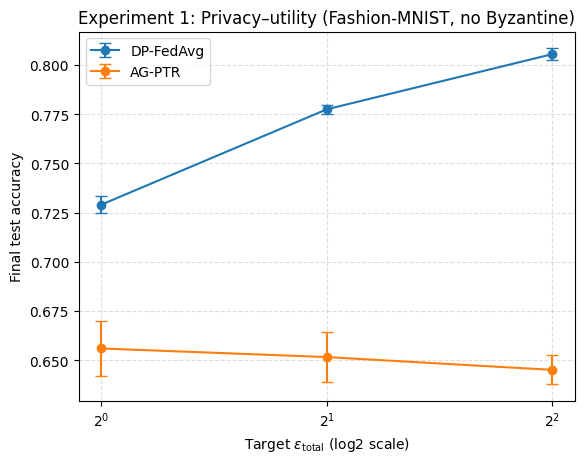

Saved: results/exp1_privacy_utility.png
Copied to: figs/exp1_privacy_utility.png


In [13]:
# Cell 13 — FULL Experiment 1 sweep + plot (FedAvg vs AG-PTR with tuned pub_scale)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Experiment 1 grid (FULL RUN)
# -----------------------------
EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

DELTA = 1e-5
ROUNDS = 180
NUM_CLIENTS = 6000
CLIENTS_PER_ROUND = 100
LOCAL_EPOCHS = 10
BATCH_SIZE = 10
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

# DP-FedAvg clip
CLIP_C = 1.0

# AG-PTR hyperparams (FIXED across eps)
TAU = 80
RHO = 0.79
SEL_FACTOR = 2.0

# Public anchor computation
PUB_EPOCHS = 1
PUB_BS = len(public_idx)

# Choose pub_scale (from your pilot sweep)
# Option A: If you ran the pilot cell that printed `best`, use:
try:
    BEST_PUB_SCALE = float(best["pub_scale"])
except Exception:
    # Option B: manually set it here if `best` doesn't exist
    BEST_PUB_SCALE = 0.05  # <-- CHANGE THIS to your chosen value

print("Using BEST_PUB_SCALE =", BEST_PUB_SCALE)

rows = []

for eps in EPS_GRID:
    # -----------------------------
    # DP-FedAvg (3 seeds)
    # -----------------------------
    fa_accs = []
    for sd in SEEDS:
        acc, achieved_eps, nm = train_dp_fedavg(
            sd, eps, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
            rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
            lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
            clip_C=CLIP_C
        )
        fa_accs.append(acc)

    rows.append({
        "method": "DP-FedAvg",
        "eps_target": eps,
        "acc_mean": float(np.mean(fa_accs)),
        "acc_std": float(np.std(fa_accs)),
    })

    # -----------------------------
    # AG-PTR (3 seeds)
    # -----------------------------
    ag_accs = []
    ag_accepts = []
    ag_clips = []

    for sd in SEEDS:
        acc, achieved_eps, (nm_sel, nm_rel), ar, avg_contrib, clip_rate = train_ag_ptr(
            sd, eps, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
            rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
            lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
            rho=RHO, tau=TAU, sel_factor=SEL_FACTOR,
            public_indices=public_idx, public_epochs=PUB_EPOCHS, public_batch_size=PUB_BS,
            pub_scale=BEST_PUB_SCALE,
            debug=False
        )
        ag_accs.append(acc)
        ag_accepts.append(ar)
        ag_clips.append(clip_rate)

    rows.append({
        "method": "AG-PTR",
        "eps_target": eps,
        "acc_mean": float(np.mean(ag_accs)),
        "acc_std": float(np.std(ag_accs)),
        "accept_rate_mean": float(np.mean(ag_accepts)),
        "clip_rate_mean": float(np.mean(ag_clips)),
        "pub_scale": float(BEST_PUB_SCALE),
        "tau": float(TAU),
        "rho": float(RHO),
        "sel_factor": float(SEL_FACTOR),
    })

df = pd.DataFrame(rows)
print(df)

# -----------------------------
# Save CSV
# -----------------------------
os.makedirs("results", exist_ok=True)
csv_path = "results/exp1_privacy_utility.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# -----------------------------
# Plot (accuracy vs epsilon)
# -----------------------------
plt.figure()
for method in df["method"].unique():
    sub = df[df["method"] == method].sort_values("eps_target")
    plt.errorbar(
        sub["eps_target"],
        sub["acc_mean"],
        yerr=sub["acc_std"],
        marker="o",
        capsize=4,
        label=method
    )

plt.xscale("log", base=2)
plt.xlabel(r"Target $\varepsilon_{\mathrm{total}}$ (log2 scale)")
plt.ylabel("Final test accuracy")
plt.title("Experiment 1: Privacy–utility (Fashion-MNIST, no Byzantine)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

png_path_results = "results/exp1_privacy_utility.png"
plt.savefig(png_path_results, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", png_path_results)

# Also save into a figs/ folder to upload to Overleaf easily
os.makedirs("figs", exist_ok=True)
png_path_figs = "figs/exp1_privacy_utility.png"
import shutil
shutil.copyfile(png_path_results, png_path_figs)
print("Copied to:", png_path_figs)
